In [1]:
from uproot_io import Events, View
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [13]:
random_numbers = np.random.randint(0, max(events.event_number), 1000)

In [3]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    particleType = []
    
    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        
        particleType.append(pdg)
        if pdg == 0:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
        
        else:
            best_inliers = []
            best_model = None
            sample_size = 10
            max_iterations = 100
            #inlier_threshold = 2.0

            for _ in range(max_iterations):
                sample_size = min(sample_size, len(x))
                sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                x_sample = x[sample_indices]
                z_sample = z[sample_indices]

                m, c = fit_line(x_sample, z_sample)
                residuals = calculate_residuals(x, z, m, c)
                inliers = np.where(residuals < (0.15*xlen))[0]

                if len(inliers) > len(best_inliers):
                    best_inliers = inliers
                    best_model = (m, c)

            if len(best_inliers) > 0:
                m, c = best_model
                gradients.append(m)
                intercepts.append(c)
                resis.append(1)

            else:
                gradients.append(0)
                intercepts.append(0)
                resis.append(0)
    
    return np.array(np.stack((gradients, intercepts, resis, particleType)))

In [9]:
import math
#all 0 = unimportant particle
#all 1 = failed fit

def coords(event_number):
    array = inlierplot(event_number)
    m = array[0, :]
    c = array[1, :]
    r = array[2, :]
    part = array[3, :]
    
    lall = []
    tall = []
    ratio = []
    
    #print(part)
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        if part[i] != 0 and r[i] != 0:
            x = events.reco_hits_x_w[i+idx[0]]
            z = events.reco_hits_w[i+idx[0]]
            
            if len(x) > 30:
                znew = z - c[i]

                angle = -math.atan(m[i])

                l = x * np.cos(angle) - znew * np.sin(angle)
                t = x * np.sin(angle) + znew * np.cos(angle)

                lall.append(l)
                tall.append(t)
                #plt.scatter(l,t)

                tdiff = np.abs(max(t)-min(t))
                #ldiff = np.abs(max(l)-min(l))

                margin = tdiff*0.05
                inside = [x for x in t if x <= margin and x >= -margin]
                ratio.append(len(inside)/len(t))
    
    newpart = part[part != 0]
    
    return newpart, ratio

In [16]:
def ratiohistplot():
    tracks = []
    showers = []
    tnumber = []
    snumber = []
    tindex = []
    sindex = []
        
    for n in random_numbers:
        part, vol = coords(n)
        for i in range(len(vol)):
            #if sd[i] != 0. and sd[i] != -0. and total[i] <= 20:
            if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                showers.append(vol[i])
                snumber.append(n)
                sindex.append(i)
            else:
                tracks.append(vol[i])
                tnumber.append(n)
                tindex.append(i)
    
    #print(max(showers))
    bin_edges = np.arange(0, 1.05, 0.05)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.05, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.05, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Ratio of particles close to fitted line')
    plt.legend()
    plt.show()
    
    showers = np.array(showers)
    snumber = np.array(snumber)
    sindex = np.array(sindex)
    tracks = np.array(tracks)
    tnumber = np.array(tnumber)
    tindex = np.array(tindex)
    
    ssorted = np.argsort(showers)
    showers = showers[ssorted]
    snumber = snumber[ssorted]
    sindex = sindex[ssorted]
    
    tsorted = np.argsort(tracks)
    tracks = tracks[tsorted]
    tnumber = tnumber[tsorted]
    tindex = tindex[tsorted]
        
    return showers, snumber, sindex, tracks, tnumber, tindex

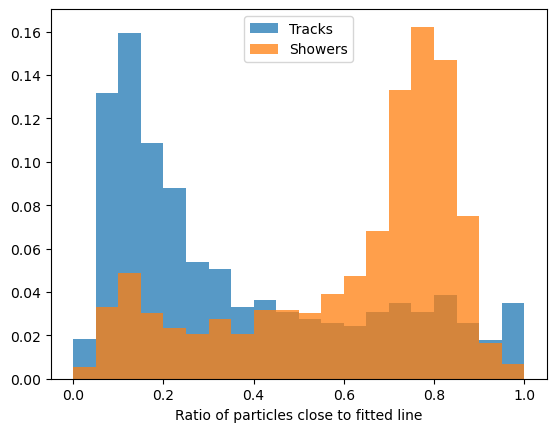

In [17]:
sh1, sn1, si1, tr1, tn1, ti1 = ratiohistplot()

In [18]:
def connectiondist(event_number):
    totals = []
    parts = []
    
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        x = events.reco_hits_x_w[i+idx[0]]
        z = events.reco_hits_w[i+idx[0]]
        part = events.mc_pdg[i+idx[0]]
        
        if part != 0:
            if (len(x)-1) != 0:
                total_distance = 0.0
                for j in range(len(x) - 1):
                    distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                    total_distance += distance
                meandist = total_distance/(len(x)-1)
                totals.append(meandist)
                parts.append(part)
    
    return np.array(totals), np.array(parts)

In [20]:
def connecthistplot():
    tracks = []
    showers = []
    tnumber = []
    snumber = []
    tindex = []
    sindex = []
    
    for n in random_numbers:
        total, part = connectiondist(n)
        for i in range(len(total)):
            if total[i] != 0. and total[i] != -0. and total[i] <= 20:
                if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                    showers.append(total[i])
                    snumber.append(n)
                    sindex.append(i)
                else:
                    tracks.append(total[i])
                    tnumber.append(n)
                    tindex.append(i)
    
    #newshowers = [x for x in showers if x > 2]
    
    bin_edges = np.arange(0, 15.5, 0.5)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.5, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.5, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Mean Connection Distance')
    plt.legend()
    plt.show()
    
    showers = np.array(showers)
    snumber = np.array(snumber)
    sindex = np.array(sindex)
    tracks = np.array(tracks)
    tnumber = np.array(tnumber)
    tindex = np.array(tindex)
    
    ssorted = np.argsort(showers)
    showers = showers[ssorted]
    snumber = snumber[ssorted]
    sindex = sindex[ssorted]
    
    tsorted = np.argsort(tracks)
    tracks = tracks[tsorted]
    tnumber = tnumber[tsorted]
    tindex = tindex[tsorted]
        
    return showers, snumber, sindex, tracks, tnumber, tindex

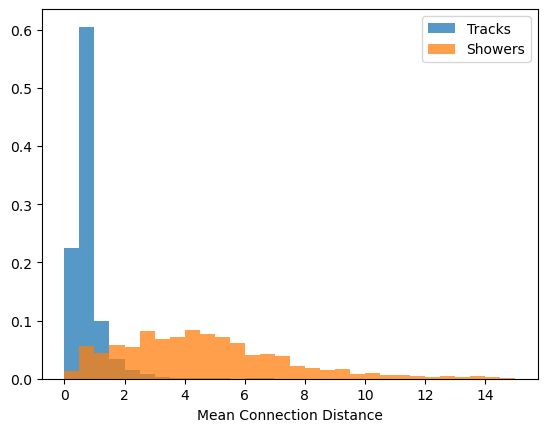

In [22]:
sh2, sn2, si2, tr2, tn2, ti2 = connecthistplot()

In [23]:
def energy(event_number):
    """needs to return energy in last X% over total energy"""
    
    particleType = np.array([])
    E = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]        
        
        # Discarding particles with no hits
        if x.size <= 5:
            continue
            
        else:
            
            # Get the last 30% of the energy data
            percent = int(0.8 * len(adc))
            X = adc[percent:]
            Xsum = np.sum(X)
            
            total = np.sum(adc)
            result = Xsum / total
            
            E = np.append(E, result)
            
            # Finding the particle type
            pdg = events.mc_pdg[i]
            particleType = np.append(particleType, pdg) 
            
    return E, particleType

In [25]:
def energyhistplot():
    tracks = []
    showers = []
    tnumber = []
    snumber = []
    tindex = []
    sindex = []
        
    for n in random_numbers:
        vol, part = energy(n)
        for i in range(len(vol)):
            if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                showers.append(vol[i])
                snumber.append(n)
                sindex.append(i)
            else:
                tracks.append(vol[i])
                tnumber.append(n)
                tindex.append(i)
    
    #print(max(showers))
    bin_edges = np.arange(0, 1.05, 0.05)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.05, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.05, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Ratio of particles close to fitted line')
    plt.legend()
    plt.show()
    
    showers = np.array(showers)
    snumber = np.array(snumber)
    sindex = np.array(sindex)
    tracks = np.array(tracks)
    tnumber = np.array(tnumber)
    tindex = np.array(tindex)
    
    ssorted = np.argsort(showers)
    showers = showers[ssorted]
    snumber = snumber[ssorted]
    sindex = sindex[ssorted]
    
    tsorted = np.argsort(tracks)
    tracks = tracks[tsorted]
    tnumber = tnumber[tsorted]
    tindex = tindex[tsorted]
        
    return showers, snumber, sindex, tracks, tnumber, tindex

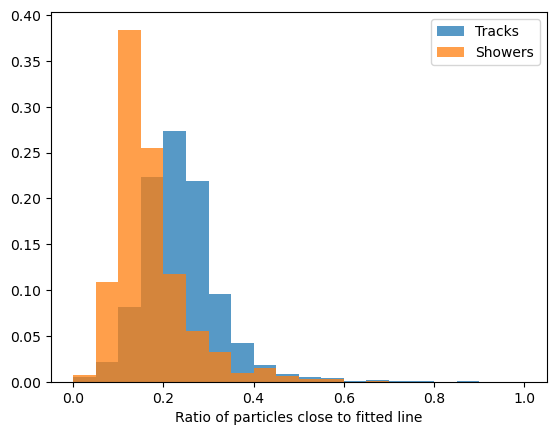

In [26]:
sh3, sn3, si3, tr3, tn3, ti3 = energyhistplot()

In [41]:
def correlationmatrix():
    #if
    
    #sh1, sn1, si1, tr1, tn1, ti1
    array1 = np.column_stack((np.array([sn1, si1, sh1])))
    array2 = np.column_stack((np.array([sn2, si2, sh2])))
    array3 = np.column_stack((np.array([sn3, si3, sh3])))

    # Extract unique event number-particle index combinations from each array
    set1 = set(map(tuple, array1[:, :2]))
    set2 = set(map(tuple, array2[:, :2]))
    set3 = set(map(tuple, array3[:, :2]))

    # Find the common combinations
    common_combinations = set1.intersection(set2, set3)

    # Convert common combinations back to NumPy array
    common_combinations_array = np.array(list(common_combinations))

    # Filter data based on common combinations
    result1 = array1[np.isin(array1[:, :2], common_combinations_array).all(axis=1), 2]
    result2 = array2[np.isin(array2[:, :2], common_combinations_array).all(axis=1), 2]
    result3 = array3[np.isin(array3[:, :2], common_combinations_array).all(axis=1), 2]
    
    sorting_indices = np.lexsort((common_combinations_array[:, 1], common_combinations_array[:, 0]))
    result1 = result1[sorting_indices]
    result2 = result2[sorting_indices]
    result3 = result3[sorting_indices]
    
    # Combine results into a single array
    combined_results = np.vstack((result1, result2, result3))

    # Transpose the array to have variables in rows and observations in columns
    #x = combined_results.T
    
    print(np.corrcoef(combined_results))

In [42]:
correlationmatrix()

[[1.         0.95939329 0.96559218]
 [0.95939329 1.         0.98850361]
 [0.96559218 0.98850361 1.        ]]
